### Задание 2

Имеются данные adult.csv (см. в материалах к занятию)

Целевой переменной является уровень дохода income (крайний правый столбец).

Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

#### Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.


Вынесем все, что понадобится, заранее

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('adult.csv')
df.head(1)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Пропусков нет, прям блеск, а не датасет

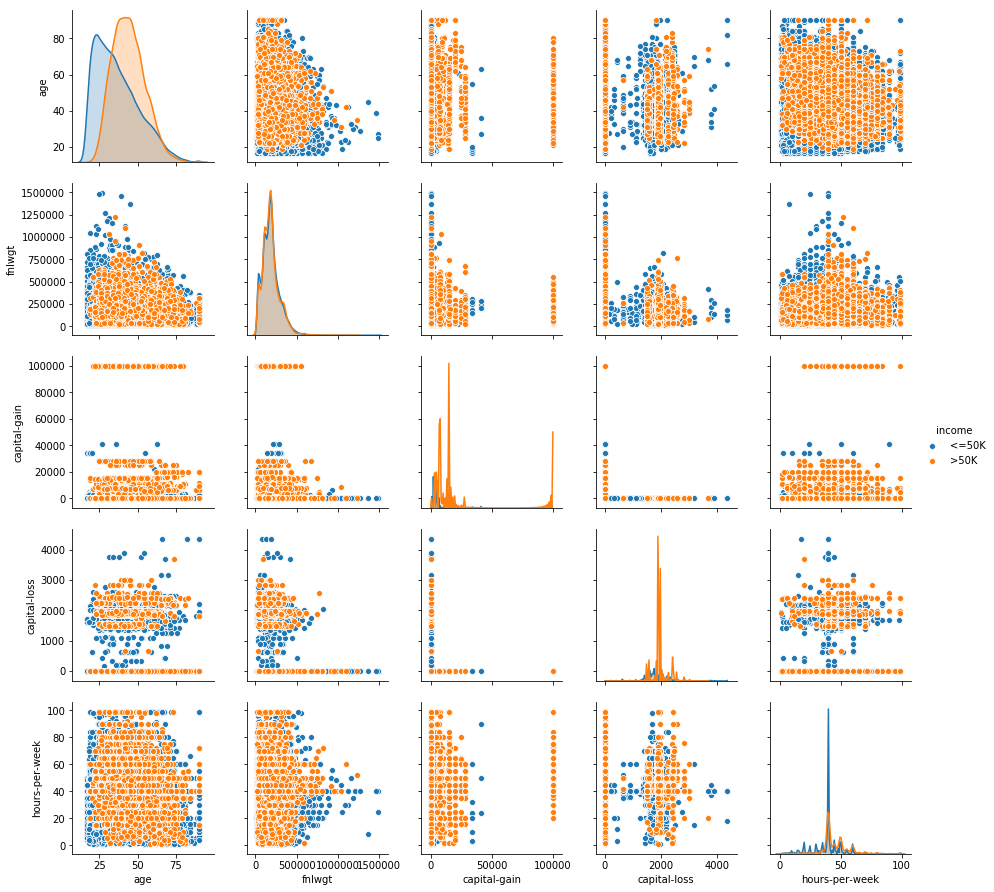

In [4]:
sns.pairplot(df[['age', 'fnlwgt', 'capital-gain', 'capital-loss','hours-per-week','income']], hue='income')

Подготовим фичи и посчитаем логистическую регрессию

In [5]:
def make_features_scaled(df, num_features, scaler):
    df_scaled = scaler.fit_transform(df[num_features])
    df_scaled = pd.DataFrame(df_scaled, columns=num_features)
    return df_scaled

In [6]:
def make_features_cat(df, cat_features):
    for each in cat_features:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [7]:
df['native-country'].value_counts(normalize=True)[:5]

United-States    0.897424
Mexico           0.019471
?                0.017546
Philippines      0.006040
Germany          0.004218
Name: native-country, dtype: float64

Значения по стране рождения сильно скошены в сторону USA, поэтому просто введем флаг is_from_usa 

In [8]:
df['is_from_usa'] = df.apply(lambda x : 1 if x['native-country'] == 'United-States' else 0, axis=1)
df = df.drop(labels='native-country', axis=1)
df['is_from_usa'].value_counts(normalize=True)

1    0.897424
0    0.102576
Name: is_from_usa, dtype: float64

In [9]:
df.income = df.income.map({'<=50K' : 0, '>50K' : 1})
df.income.value_counts()

0    37155
1    11687
Name: income, dtype: int64

In [10]:
df['is_male'] = df.gender.map({'Female' : 0, 'Male' : 1})
df = df.drop(labels='gender', axis=1)
df.is_male.value_counts()

1    32650
0    16192
Name: is_male, dtype: int64

У нас есть два близких признака: education и educational-num. Второй является по сути LabelEncoding для первого, поэтому уберем education

In [11]:
df = df.drop(labels='education', axis=1)

In [12]:
categorical_features = ['workclass', 'marital-status', 'occupation', 'relationship', 'race']
numeric_features =  ['fnlwgt', 'capital-gain', 'capital-loss']

df = make_features_cat(df, categorical_features)
df = df.drop(labels=categorical_features, axis=1)

df_scaled = make_features_scaled(df, numeric_features, StandardScaler())
df = df.drop(labels=numeric_features, axis=1)
df = pd.concat([df, df_scaled], axis=1)

In [13]:
df.head()

,age,educational-num,hours-per-week,income,is_from_usa,is_male,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,fnlwgt,capital-gain,capital-loss
0,25,7,40,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0.351675,-0.144804,-0.217127
1,38,9,50,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,-0.945524,-0.144804,-0.217127
2,28,12,40,1,1,1,0,0,1,0,...,0,0,0,0,0,0,1,1.394723,-0.144804,-0.217127
3,44,10,40,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,-0.277844,0.886874,-0.217127
4,18,10,30,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,-0.815954,-0.144804,-0.217127


Обучим модель и посмотрим на качество

In [14]:
y = df.income
df = df.drop('income', axis=1)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [15]:
model = LogisticRegression(C = 0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8560753403623708

In [16]:
roc_auc_score(model.predict(X_test), y_test)

0.8104675715295843